# Studies on multi-controlled Toffoli decomposition

Valter Uotila, PhD student, University of Helsinki

This is a solution proposal for Classiq Coding Challenge where the problem is to decompose 14-control qubit toffoli gate into two and single qubit gates using max 5 ancilla qubits. The document has somewhat esseistic style because I tend to think by writing.

Because number 14 feels more or less quite arbitrary and it is also quite large, this code calculates a possible decomposition for any given number of control qubits. The idea is heavily based on the [classical book of Niels and Chuang](http://csis.pace.edu/~ctappert/cs837-19spring/QC-textbook.pdf) and the [excellent blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney. Also, the paper [Elementary gates for quantum computation](https://arxiv.org/abs/quant-ph/9503016v1) has been useful. Maybe everyone opens first the classical book of Niels and Chuang. One can find there the following exercise:

_**Exercise 4.29: Find a circuit containing $\mathcal{O}(n^2)$ Toffoli, CNOT and single qubits gates which implements a $C^n(X)$ gate for $n > 3$ using no work qubits.**_

This exercise appears to be surprisingly deep and hard. It is also connected to the problem in the competition although it does not include the idea of minimal depth. The [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html) by Craig Gidney is about this exercise.

My own contribution is the explanation in this document and the implementation. I completed the implementation with Pennylane because Amazon Braket supports it better than Qiskit.

**Table of contents:**

1. Solution proposal without ancilla qubits
    1. Implementation of a simple function that returns square roots for NOT gate
    2. Iteratively decompose using square root gates
2. Solution proposal with ancilla qubits i.e. the classical solution
    1. Iteratively decompose multi-control toffoli gates
3. Use ZH-calculus to optimize T-count
    1. Implementation of ZH 
4. Running the code for 14-qubit case

In [1]:
import pennylane as qml
from pennylane import numpy as np

from qiskit import QuantumCircuit, QuantumRegister

## Solution proposal without ancilla qubits

### Square roots of NOT gate and finding fundamental decompositions from Niels and Chuang

As Gidney explains in the [blog post](https://algassert.com/circuits/2015/06/22/Using-Quantum-Gates-instead-of-Ancilla-Bits.html), every logical quantum gate has the corresponding square root gate. When we note the fact that diagonal matrices are easy to square and 
$$
Z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
$$
we obtain that 
$$
\sqrt[n]{Z} = \begin{bmatrix}
1 & 0 \\
0 & e^{i\frac{\pi}{n}}
\end{bmatrix}.
$$

When we change the computational basis to Hadamard -basis, taking the square roots become (at least theoretically) easier: $X = HZH$. This is also the reason for Hadamard-gates in the example decomposition in the Classiq's problem description. The $T$-gates and $S$-gates are the certain square roots of $Z$-gate, $T = \sqrt[4]{Z}$ and $S = \sqrt[2]{Z}$. So actually $T$ and $S$ gates are just a clever way to hide $X$ gates in the decomposition! Gidney reads Niels and Chuang very carefully and notices the power of the following circuit which corresponds to the Toffoli gate:

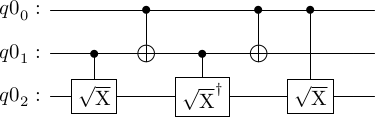

In [2]:
from qiskit.circuit.library.standard_gates import SXGate, SGate, TGate, IGate

qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.append(SXGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SXGate().control(), [qr[0], qr[2]])

circuit.draw(output='latex')

This circuit corresponds to the Toffoli case $V = (1-i)(I+iX)/2$ presented in Figure 4.8 in Niels and Chuang. Furthermore we can change the basis to Hadamard. Recall that $H\sqrt{X}H = \sqrt{Z} = S$. Thus we can write:

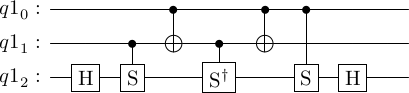

In [3]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)
circuit.append(SGate().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().inverse().control(), [qr[1], qr[2]])
circuit.cx(0, 1)
circuit.append(SGate().control(), [qr[0], qr[2]])
circuit.h(2)

circuit.draw(output='latex')

If one wants a still bit more concrete visualition of the circuit, it is easy [to construct it to Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22Z^%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22Z^-%C2%BD%22],[%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22Z^%C2%BD%22],[1,1,%22H%22]]}) and check that is encodes the Toffoli gate. The circuit also encodes multi-control Toffoli gate when we consider that the first wire is a bundle of multiple wires.

But this construction does not fullfill the requirement of the exercise 4.9 nor the competition description since the control bits are attached to square root and $S$ gates which is not allowed. Careful reading of Niels and Chuang solves this problem as Gidney points out. We can express the controlled-square root gates (also $S$ gates) above using the following decomposition that is presented in Figure 4.6 in Niels and Chuang. After all, this decomposition is quite well known and classical result. For an arbitrary unitary gate $U$, who is controlled by a single qubit, the decomposition is:

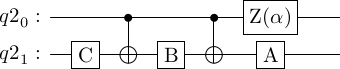

In [4]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.append(IGate(label = "C"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "B"), [qr[1]])
circuit.cx(0, 1)
circuit.append(IGate(label = "A"), [qr[1]])
circuit.append(IGate(label = "Z(\\alpha)"), [qr[0]])

circuit.draw(output='latex')

where
$$
Z(\alpha) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\alpha}
\end{bmatrix}
$$
and $Z(\alpha)AXBXC = U$ and $ABC = I$.

If we compare this construction to Figure 4.9 in Niels and Chuang, we can notice that $A = T$, $B = T^{\dagger}$, $C = I$ and $Z(\alpha) = T$ when we have the controlled $S$ gate. Now $ABC = TT^{\dagger} = I$ and $e^{(i\alpha)}AXBX = S$. So we can deduce that the following circuit implements controlled-$S$ gate:

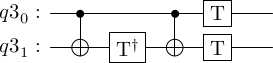

In [5]:
qr = QuantumRegister(2)
circuit = QuantumCircuit(qr)

# This circuit is just to visualization and the identity gate is simply a place holder for the labels
circuit.cx(0, 1)
circuit.append(TGate().inverse(), [qr[1]])
circuit.cx(0, 1)
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.draw(output='latex')

We can substitute the decomposition above into the circuit with controlled $S$ gates. We then obtain:

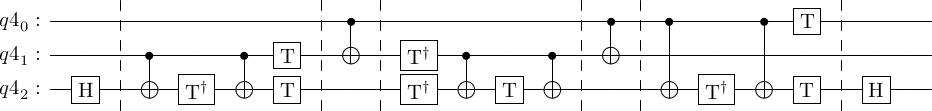

In [6]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

# First substitution
# circuit.append(SGate().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.barrier()


circuit.cx(0, 1)

# Second substitution for inverse S
# circuit.append(SGate().inverse().control(), [qr[1], qr[2]])

circuit.barrier()
circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(1, 2)
circuit.append(TGate(), [qr[2]])
circuit.cx(1, 2)
circuit.barrier()

circuit.cx(0, 1)

# Third substitution
#circuit.append(SGate().control(), [qr[0], qr[2]])

circuit.barrier()
circuit.cx(0, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[0]])
circuit.barrier()

circuit.h(2)

circuit.draw(output='latex')

which can be simplied to the following circuit:

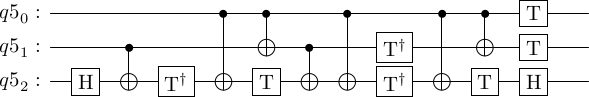

In [7]:
qr = QuantumRegister(3)
circuit = QuantumCircuit(qr)

circuit.h(2)

circuit.cx(1, 2)
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.append(TGate(), [qr[2]])

circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.cx(0, 2)

circuit.append(TGate().inverse(), [qr[1]])
circuit.append(TGate().inverse(), [qr[2]])
circuit.cx(0, 2)
circuit.cx(0, 1)

circuit.append(TGate(), [qr[2]])
circuit.append(TGate(), [qr[1]])
circuit.append(TGate(), [qr[0]])

circuit.h(2)

circuit.draw(output='latex')

We see that the depth of this circuit ([see the circuit in Quirk](https://algassert.com/quirk#circuit={%22cols%22:[[%22X%22,%22X%22,%22X%22],[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[%22%E2%80%A2%22,%22X%22],[1,%22%E2%80%A2%22,%22X%22],[%22%E2%80%A2%22,1,%22X%22],[1,%22Z^-%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[%22Z^%C2%BC%22,%22Z^%C2%BC%22,%22Z^%C2%BC%22],[1,1,%22H%22]]})) is smaller than the one Niels and Chuang represent but not better than in the problem description example. The circuit in the Classiq's problem description has a mistake: the fourth CNOT should be between $q_0$ and $q_2$ not between $q_1$ and $q_2$. The correct circuit is [here](https://algassert.com/quirk#circuit={%22cols%22:[[1,1,%22H%22],[1,%22%E2%80%A2%22,%22X%22],[1,1,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22%E2%80%A2%22,%22X%22],[1,%22Z^%C2%BC%22,%22Z^-%C2%BC%22],[%22%E2%80%A2%22,1,%22X%22],[%22%E2%80%A2%22,%22X%22],[1,1,%22Z^%C2%BC%22],[1,%22Z^-%C2%BC%22],[%22Z^%C2%BC%22,1,%22H%22],[%22%E2%80%A2%22,%22X%22]]}). The number of gates is the same in all of the circuits.

### Iteratively and automatically decompose larger multi-control Toffoli gates

In this section I code a program that iteratively decomposes multi-toffoli gates into the previously represented smaller circuits. In my opinion Pennylane supports better gates based on custom unitaries, so I develop the algorithm using it. Algorithm iteratively removes all the multi-control gates from the circuit expressed in the cell [3]. Note that the circuit in cell [3] does not draw these wires but we consider that the first wire is a bundle of wires.

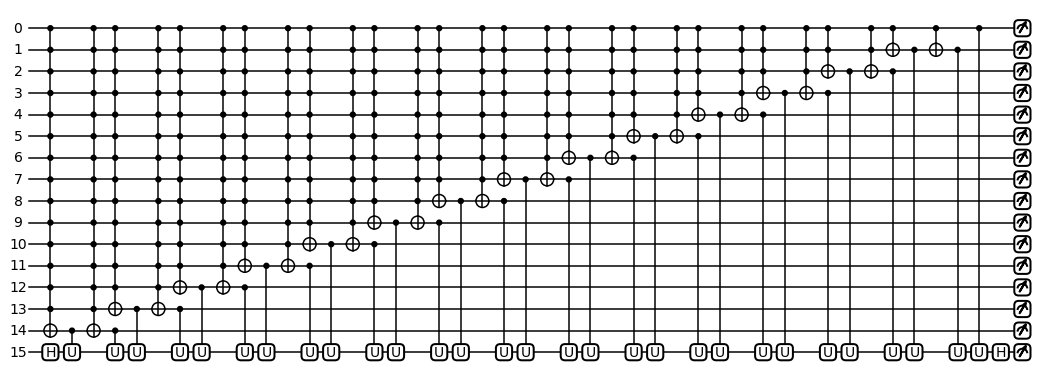

In [25]:
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)
dev2 = qml.device('lightning.qubit', wires=target)

def get_square_root_z(n):
    return np.array([[1, 0], [0, np.exp(1j*np.pi/n)]])
    
@qml.qnode(dev)
def multi_Toffoli_step1_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.adjoint(ControlledQubitUnitary(square_root_matrix, control_wires = n_ctrl_wires, wires = target))
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        qml.ControlledQubitUnitary(square_root_matrix, control_wires = n_ctrl_wires, wires = target)
    
    qml.ControlledQubitUnitary(square_root_matrix, control_wires = 0, wires = target)
    qml.Hadamard(wires=target)
    return qml.state()

square_root_z = get_square_root_z(1)
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(multi_Toffoli_step_circuit, show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)

Next we remove the single control gates that are not CNOTs. Here we apply the rule from cell [5]. Again, the cell [5] shows only the first step of the iteration. 

In [ ]:
def controlled_qubit_unitary_decomposed(square_root_matrix, control_wires = n_ctrl_wires, wires = target, adjoint = False):
    return None

In [ ]:
n_ctrl = 14 # number of control qubits
target = n_ctrl + 1
dev = qml.device("default.qubit", wires=target)
dev2 = qml.device('lightning.qubit', wires=target)

def get_square_root_z(n):
    return np.array([[1, 0], [0, np.exp(1j*np.pi/n)]])
    
@qml.qnode(dev)
def multi_Toffoli_step1_circuit(n_control_wires):
    all_ctrl_wires = range(n_control_wires + 1)
    target = n_control_wires + 1
    nth_square_root = target - n_control_wires
    square_root_matrix = None
    
    qml.Hadamard(wires=target)
    for i in all_ctrl_wires[:-1]:
        ctrl_wires = all_ctrl_wires[:-i - 1]
        n_ctrl_wires = len(ctrl_wires)
        square_root_matrix = get_square_root_z(2**i)
        
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        #qml.ControlledQubitUnitary(square_root_matrix, control_wires = n_ctrl_wires, wires = target)
        controlled_qubit_unitary_decomposed(square_root_matrix, control_wires = n_ctrl_wires, wires = target, adjoint = True)
        qml.MultiControlledX(control_wires = ctrl_wires, wires = n_ctrl_wires)
        controlled_qubit_unitary_decomposed(square_root_matrix, control_wires = n_ctrl_wires, wires = target, adjoint = True)
    
    qml.ControlledQubitUnitary(square_root_matrix, control_wires = 0, wires = target)
    qml.Hadamard(wires=target)
    return qml.state()

square_root_z = get_square_root_z(1)
qml.drawer.use_style('black_white')
fig, ax = qml.draw_mpl(multi_Toffoli_step_circuit, show_all_wires = True)(n_ctrl)
fig.set_size_inches(fig.get_size_inches()[0]*0.3, fig.get_size_inches()[1]*0.3)